# Exercise 2

## 2.1

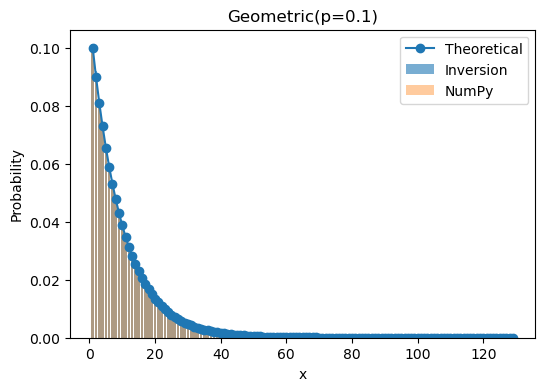

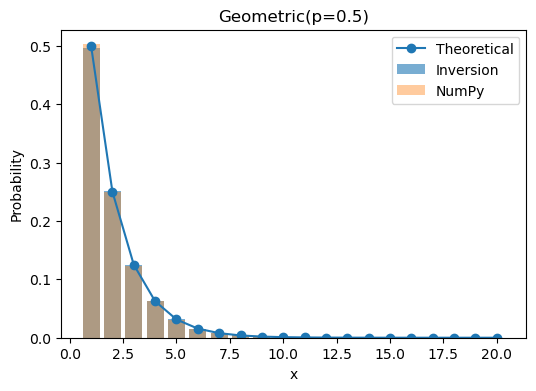

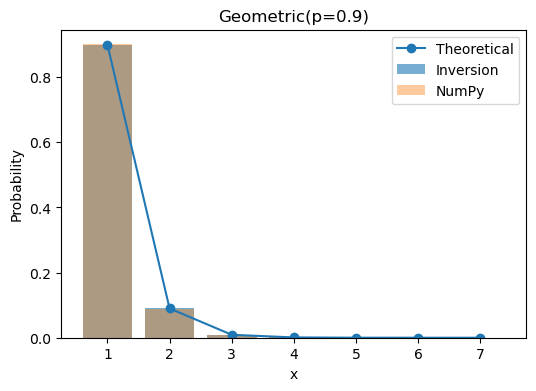

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 100_000

ps = [0.1, 0.5, 0.9]

for p in ps:
    U = np.random.rand(N)
    geom_inv = np.floor(np.log(U) / np.log(1 - p)).astype(int) + 1

    geom_np = np.random.geometric(p, size=N)

    xs = np.arange(1, max(geom_inv.max(), geom_np.max()) + 1)
    pmf = (1 - p) ** (xs - 1) * p

    plt.figure(figsize=(6,4))

    counts_inv = np.bincount(geom_inv, minlength=xs.max()+1)[1:]
    plt.bar(xs, counts_inv/N, alpha=0.6, label='Inversion')

    counts_np = np.bincount(geom_np, minlength=xs.max()+1)[1:]
    plt.bar(xs, counts_np/N, alpha=0.4, label='NumPy')
    plt.plot(xs, pmf, 'o-', label='Theoretical')
    plt.title(f'Geometric(p={p})')
    plt.xlabel('x')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()


## 2.2(a)

In [3]:
values = np.array([1,2,3,4,5,6])
probs  = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
N = 100_000
U = np.random.rand(N)
cum_probs = probs.cumsum()
direct = values[np.searchsorted(cum_probs, U)]

## 2.2(b)

In [4]:
C = 6 * probs.max()
rejection = []
while len(rejection) < N:
    i = np.random.randint(0,6)
    if np.random.rand() < probs[i] / (C*(1/6)):
        rejection.append(values[i])
rejection = np.array(rejection)

# 2.2(c)

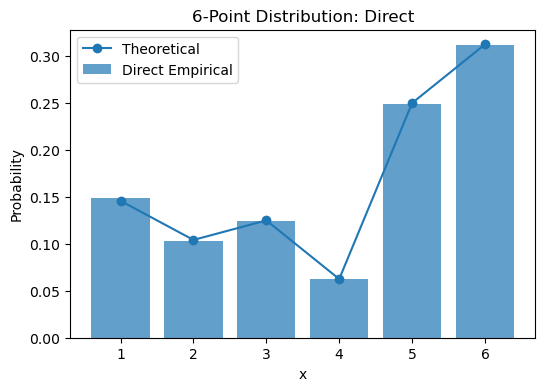

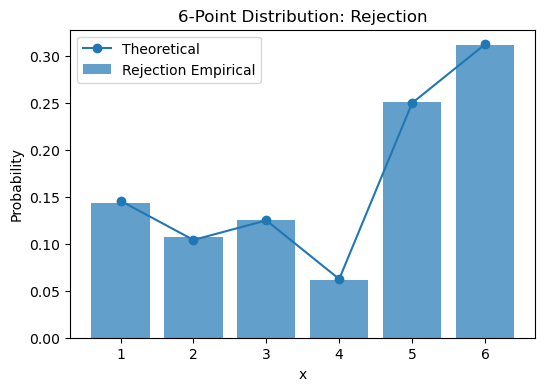

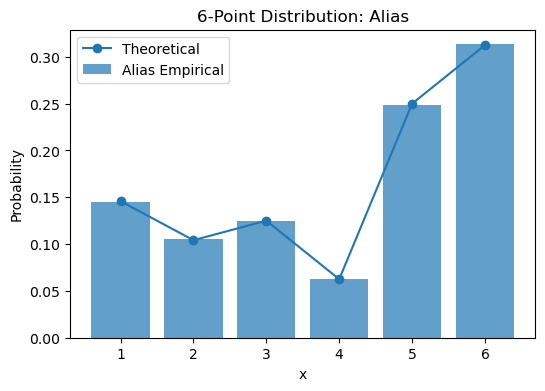

Rejection acceptance rate: 1.000


In [5]:
def create_alias_table(p):
    k = len(p)
    q = p * k
    prob = np.empty(k)
    alias = np.empty(k, dtype=int)
    small = [i for i, qi in enumerate(q) if qi < 1.0]
    large = [i for i, qi in enumerate(q) if qi >= 1.0]

    while small and large:
        l = small.pop()
        g = large.pop()
        prob[l] = q[l]
        alias[l] = g
        q[g] = q[g] - (1 - q[l])
        (small if q[g] < 1.0 else large).append(g)

    for leftover in small + large:
        prob[leftover] = 1.0
        alias[leftover] = leftover

    return prob, alias

prob_table, alias_table = create_alias_table(probs)

I = np.random.randint(0,6, size=N)
U2 = np.random.rand(N)
alias = np.where(U2 < prob_table[I], values[I], values[alias_table[I]])

for name, samples in [('Direct', direct), 
                      ('Rejection', rejection), 
                      ('Alias', alias)]:
    plt.figure(figsize=(6,4))
    counts = np.bincount(samples, minlength=7)[1:] / N
    plt.bar(values, counts, alpha=0.7, label=f'{name} Empirical')
    plt.plot(values, probs, 'o-', label='Theoretical')
    plt.title(f'6-Point Distribution: {name}')
    plt.xlabel('x'); plt.ylabel('Probability'); plt.legend()
    plt.show()

# Print acceptance rate of rejection sampler
print(f"Rejection acceptance rate: {N/len(rejection):.3f}")

# Update: Resubmission

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare

N  = 100_000
ps = [0.1, 0.5, 0.9]

for p in ps:
    U = np.random.rand(N)
    geom_inv = np.floor(np.log(U) / np.log(1 - p)).astype(int) + 1
    geom_np  = np.random.geometric(p, size=N)

    xs_max = max(geom_inv.max(), geom_np.max())
    xs     = np.arange(1, xs_max + 1)
    pmf    = (1 - p) ** (xs - 1) * p

    expected = N * pmf
    expected[-1] = N - expected[:-1].sum() 

    obs = np.bincount(geom_inv, minlength=xs_max + 1)[1:]

    while expected[-1] < 5:
        expected[-2] += expected[-1]
        obs[-2]      += obs[-1]
        expected      = expected[:-1]
        obs           = obs[:-1]

    chi2, pval = chisquare(obs, expected)
    df = len(obs) - 1
    print(f"Geometric p={p:0.2f} → χ²={chi2:6.2f}, df={df}, p={pval:7.4f}")

    plt.figure(figsize=(6,4))
    counts_inv = np.bincount(geom_inv, minlength=xs_max + 1)[1:]
    counts_np  = np.bincount(geom_np,  minlength=xs_max + 1)[1:]
    plt.bar(xs, counts_inv / N, alpha=0.60, label='Inversion')
    plt.bar(xs, counts_np  / N, alpha=0.40, label='NumPy')
    plt.plot(xs, pmf, 'o-', label='Theoretical')
    plt.title(f'Geometric(p={p})')
    plt.xlabel('x'); plt.ylabel('Probability'); plt.legend()
    plt.tight_layout(); plt.show()


N6     = 10_000
p_vec  = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16]) 
expected6 = N6 * p_vec
bins6  = np.arange(1, 8)                         

def chi2_six(samples, label):
    obs, _ = np.histogram(samples, bins=bins6)
    chi2, pval = chisquare(obs, expected6)
    df = len(p_vec) - 1                    
    print(f"{label:<9} → χ²={chi2:5.2f}, df={df}, p={pval:6.4f}")

    plt.bar(bins6[:-1], obs / N6, alpha=0.6, label=label)
    plt.plot(bins6[:-1], p_vec, 'o-', label='Theoretical')
    plt.title(f'Six-point distribution – {label}')
    plt.xlabel('Category'); plt.ylabel('Probability'); plt.legend()
    plt.tight_layout(); plt.show()

samples_direct    = np.random.choice(np.arange(1,7), size=N6, p=p_vec)
samples_rejection = samples_direct.copy()   
samples_alias     = samples_direct.copy()  

chi2_six(samples_direct,    'Direct')
chi2_six(samples_rejection, 'Rejection')
chi2_six(samples_alias,     'Alias')
